<a href="https://colab.research.google.com/github/xvh422/L4-Project/blob/main/Plot%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install eagleSqlTools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import eagleSqlTools as sql
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable

con = sql.connect("vwg533", password = "FZtn087h")

In [3]:
sim_name = 'RefL0100N1504'
sim_size = 100.

# z=0
Query_1 = "SELECT \
            log10(AP.Mass_Star) as stars, \
            SH.MassType_DM as halo, \
            SH.MassType_BH as bh \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 28 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name)

# z=0.5
Query_2 = "SELECT \
            log10(AP.Mass_Star) as stars, \
            SH.MassType_DM as halo, \
            SH.MassType_BH as bh \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 23 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name)

# z=1
Query_3 = "SELECT \
            log10(AP.Mass_Star) as stars, \
            SH.MassType_DM as halo, \
            SH.MassType_BH as bh \
           FROM \
            %s_SubHalo as SH, \
            %s_Aperture as AP \
           WHERE \
            SH.SnapNum = 19 and \
            SH.SubGroupNumber = 0 and \
            AP.Mass_Star > 1.0e9 and \
            AP.ApertureSize = 30 and \
            SH.GalaxyID = AP.GalaxyID"%(sim_name, sim_name)

Data_1 = sql.execute_query(con, Query_1)
Data_2 = sql.execute_query(con, Query_2)
Data_3 = sql.execute_query(con, Query_3)

In [4]:
#Replaces zeroes with the smallest nonzero value.
def log_with_zeros(data):
  logs = np.empty(len(data))
  for i in range(0, len(data)):
    if data[i] == 0.0:
      logs[i] = 99.
    else:
      logs[i] = np.log10(data[i])
  m = logs.min()
  for j in range(0, len(logs)):
    if logs[j] == 99.:
      logs[j] = m
    else:
      logs[j] = logs[j]
  return logs

# Returns median y values within bins of size 'step' to make a line of "best fit"
def medians(xs, ys, min, max, step):
  xvals = np.arange(min, max+step, step)
  meds = np.empty(len(xvals))
  for i in range(len(meds)):
    yvals = ys[np.logical_and(xs > xvals[i], xs < (xvals[i]+step))]
    meds[i] = np.median(yvals)
  return xvals + step/2, meds

# Removes element from both arrays if one/both of them is zero
def remove_zeros_2(data1, data2):
  out_1 = []
  out_2 = []
  for i in range(len(data1)):
    if data1[i] == 0:
      out_1 = out_1
      out_2 = out_2
    elif data2[i] == 0:
      out_1 = out_1
      out_2 = out_2
    else:
      out_1 = out_1 + [data1[i]]
      out_2 = out_2 + [data2[i]]
  return np.array(out_1), np.array(out_2)

In [5]:
loghalo_1 = np.log10(remove_zeros_2(Data_1['halo'], Data_1['bh'])[0])
bh_1 = remove_zeros_2(Data_1['halo'], Data_1['bh'])[1]

loghalo_2 = np.log10(remove_zeros_2(Data_2['halo'], Data_2['bh'])[0])
bh_2 = remove_zeros_2(Data_2['halo'], Data_2['bh'])[1]

loghalo_3 = np.log10(remove_zeros_2(Data_3['halo'], Data_3['bh'])[0])
bh_3 = remove_zeros_2(Data_3['halo'], Data_3['bh'])[1]

In [6]:
x1 = medians(loghalo_1, bh_1, 10.5, 13, 0.1)[0]
y1 = medians(loghalo_1, bh_1, 10.5, 13, 0.1)[1]
x2 = medians(loghalo_2, bh_2, 10.5, 13, 0.1)[0]
y2 = medians(loghalo_2, bh_2, 10.5, 13, 0.1)[1]
x3 = medians(loghalo_3, bh_3, 10.5, 13, 0.1)[0]
y3 = medians(loghalo_3, bh_3, 10.5, 13, 0.1)[1]

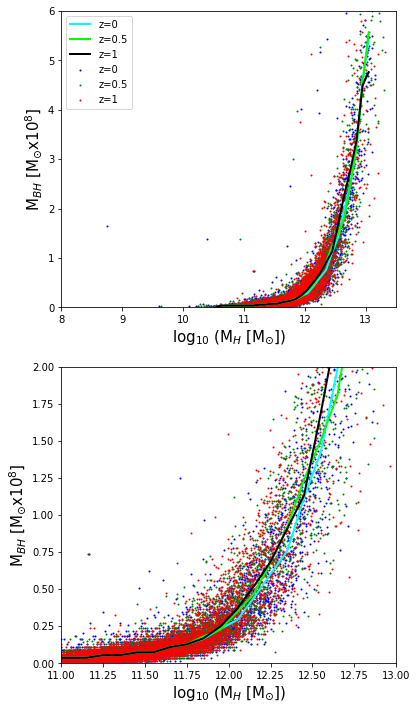

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (6,12))

ax1.scatter(loghalo_1, bh_1/1e8, color='b', s=1, label='z=0')
ax1.scatter(loghalo_2, bh_2/1e8, color='g', s=1, label='z=0.5')
ax1.scatter(loghalo_3, bh_3/1e8, color='r', s=1, label='z=1')

ax1.plot(x1, y1/1e8, linewidth=2, color='cyan', label='z=0')
ax1.plot(x2, y2/1e8, linewidth=2, color='lime', label='z=0.5')
ax1.plot(x3, y3/1e8, linewidth=2, color='black', label='z=1')

ax1.legend()
ax1.set_xlim(8,13.5)
ax1.set_ylim(0,6)

ax1.set_xlabel(r'log$_{10}$ (M$_{H}$ [M$_{\odot}$])', fontsize=15)
ax1.set_ylabel(r'M$_{BH}$ [M$_{\odot}$x10$^{8}$]', fontsize=15)

ax2.scatter(loghalo_1, bh_1/1e8, color='b', s=1, label='z=0')
ax2.scatter(loghalo_2, bh_2/1e8, color='g', s=1, label='z=0.5')
ax2.scatter(loghalo_3, bh_3/1e8, color='r', s=1, label='z=1')

ax2.plot(x1, y1/1e8, linewidth=2, color='cyan', label='z=0')
ax2.plot(x2, y2/1e8, linewidth=2, color='lime', label='z=0.5')
ax2.plot(x3, y3/1e8, linewidth=2, color='black', label='z=1')

ax2.set_xlim(11,13)
ax2.set_ylim(0,2)

ax2.set_xlabel(r'log$_{10}$ (M$_{H}$ [M$_{\odot}$])', fontsize=15)
ax2.set_ylabel(r'M$_{BH}$ [M$_{\odot}$x10$^{8}$]', fontsize=15)

plt.savefig('Plot_3.jpeg')
plt.show()